## Multi-class classification example

In this example we show how the ecgxai package can be used to easily build a classification system for multiple classes (in this case for Sinus Rhythm (NSR), Sinus Arrhythmia (SA), Sinus Bradycardia (SB) and Sinus tachycardia (STach)). We train the model on the PTB-XL dataset and use 'double residual' convolution resnet architecture. 

In [1]:
%load_ext autoreload
%autoreload 2
# We first import the required data utilities from the ecgxai package
from ecgxai.utils.dataset import PTBXLDataset
from ecgxai.utils.transforms import ApplyGain, ToTensor

# We also import some additional utilities from other packages for additionally functionality
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

In [2]:
# The PTBXL dataset class automatically downloads and extract the PTB-XL 12 lead dataset
dataset = PTBXLDataset(
    # The path parameter defines where the data should be stored and were the data can be found in the future
    path="/workspace/misc/PTB_XL", 
    # We use the ApplyGain and ToTensor transformation (chained through the compose class)
    # to format the data into the desired format. In the case of PTB-XL, all the input data
    # is devided by 1000 in the ApplyGain transform to smoothen training (see the next cell for an example).
    transform = Compose([ApplyGain(), ToTensor()]),
    # The use_numpy parameter is set to True to speed up the loading of the data
    use_numpy=True,
    # As we are classifying Sinus Rhythm (NSR), Sinus Arrhythmia (SA), Sinus Bradycardia (SB) and Sinus tachycardia (STach) 
    # in this example we tell the dataset to use the 'NSR' 'SA', 'SB' and 'STach' labels. 
    labels=['NSR', 'SA', 'SB', 'STach']
)

# We then randomly split the dataset into a train and test set using a 90%-10% split
trainset, testset = dataset.train_test_split(ratio=0.1, shuffle=True)

print("Trainset:")
trainset.print_stats()

print("\n Testset: ")
testset.print_stats()

100%|██████████| 21837/21837 [00:00<00:00, 193257.72it/s]

Using downloaded and verified file: /workspace/misc/PTB_XL/PTB_XL.tar.gz
Trainset:


-- Dataset distribution -- 
Full size: 19653
["NSR"] - Num entries: 16268 (82.8%)
["SA"] - Num entries: 700 (3.56%)
["SB"] - Num entries: 583 (2.97%)
["STach"] - Num entries: 748 (3.81%)

 Testset: 
-- Dataset distribution -- 
Full size: 2184
["NSR"] - Num entries: 1824 (83.5%)
["SA"] - Num entries: 72 (3.3%)
["SB"] - Num entries: 54 (2.47%)
["STach"] - Num entries: 78 (3.57%)


In [3]:
# The train and testset are then supplied to a pytorch dataloader which we can use to train the model
train_loader = DataLoader(
        trainset,
        batch_size=64,
        num_workers=8,
        shuffle=True
)

test_loader = DataLoader(
    testset,
    batch_size=64,
    num_workers=8
)

### Checking the data

The cell below plots the first lead of a sample from the dataset which we get using the __\_\_getitem\_\_()__ function which returns a dictionary. The raw ecg is stored under the 'waveform' key. 

dict_keys(['waveform', 'samplebase', 'gain', 'id', 'truebaseline_0', 'truebaseline_1', 'truebaseline_2', 'truebaseline_3', 'truebaseline_4', 'truebaseline_5', 'truebaseline_6', 'truebaseline_7', 'truebaseline_8', 'truebaseline_9', 'truebaseline_10', 'truebaseline_11', 'label'])


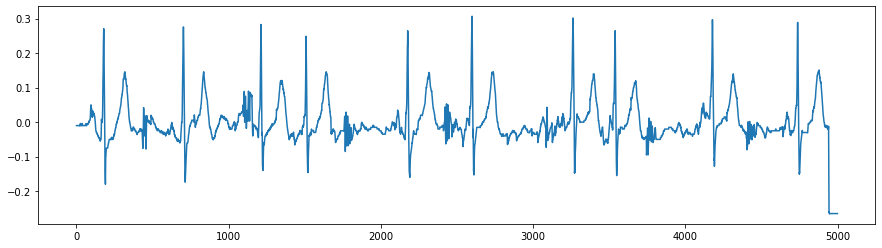

In [4]:
import matplotlib.pyplot as plt

example = trainset.__getitem__(0)

# We can plot the keys of the dictionary to see what is available in the standard dataset configuration. The 'truebaseline' 
# keys are used for baseline correction in some datasets. 
print(example.keys())

plt.figure(figsize=(15, 4))
plt.plot(example['waveform'][0])

### Initializing the model

We import the CNNDoubleResidual architecture from the ecgxai package and pass it the required hyperparameters to deal with our dataset (e.g. 12 channels, 5000 measurements per lead). We choose to subsample (half the spatial dimension) each layer to limit the required number of parameters. 

We also define adittional Sequential and Linear layer to map the CNN output to the desired 2 classes

In [5]:
import torch.nn as nn
from ecgxai.network.doubleresidual.modules import CNNDoubleResidual, Reshape

# Initualize the double reisdual convolutional resnet
cnn = CNNDoubleResidual(
    num_layers=10,
    in_sample_dim=5000,
    in_channels=12,
    kernel_size=7,
    dropout_rate=0.1,
    sub_sample_every=1,
    double_channel_every=4,
    act_func=nn.ReLU(),
    batchnorm=True
)

# use the calculate_output_dim to see what size the output of the CNN is
cnn_output_dim, cnn_output_channels, cnn_output_samples = cnn.calculate_output_dim()

# We pass this calculated size to a linear layer that then maps the data to 4 outputs per ecg
class_model = nn.Sequential(
    cnn,
    nn.Linear(cnn_output_dim, 4),
)

In [6]:
from torchinfo import summary

batch_size = 16
summary(class_model, input_size=(1, 12, 5000), depth=50)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                                       Output Shape              Param #
Sequential                                                   [1, 4]                    --
├─CNNDoubleResidual: 1-1                                     [1, 432]                  --
│    └─Sequential: 2-1                                       [1, 432]                  --
│    │    └─ResidualMaxPoolDoubleConvBlockForward: 3-1       [1, 12, 5000]             --
│    │    │    └─MaxPool1d: 4-1                              [1, 12, 5000]             --
│    │    │    └─Sequential: 4                               --                        --
│    │    │    │    └─BatchNorm1d: 5-1                       [1, 12, 5000]             24
│    │    └─ResidualMaxPoolDoubleConvBlockForward: 3         --                        --
│    │    │    └─Sequential: 4                               --                        --
│    │    │    │    └─ReLU: 5-2                              [1, 12, 5000]             --
│    

In [7]:
%load_ext autoreload
%autoreload 2
from ecgxai.systems.classification_system import ClassificationSystem
from ecgxai.utils.loss import TW
from ecgxai.utils.metrics import TMW

from torchmetrics import MetricCollection, AUROC, F1Score, Accuracy, Precision, Recall

metrics = {
   'AUROC':  TMW(
       AUROC(num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'], 
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'Precision': TMW(
       Precision(num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'Recall': TMW(
       Recall(num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'Accuracy': TMW(
       Accuracy(num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'F1': TMW(
       F1Score(num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   )
} 

metrics = MetricCollection(metrics)
    
model = ClassificationSystem(
    lr=0.001,
    mode='multi_class',
    model=class_model,
    test_metrics=metrics,
    loss=TW(nn.CrossEntropyLoss(), ['y_hat', 'label'], long_args=['label'], arg_max_args=['label'])
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['y_hat', 'label']


/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [9]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = pl.Trainer(
        max_epochs=10,
        gpus= 1 if torch.cuda.is_available() else None,
        logger=None,
        callbacks=[
            ModelCheckpoint(
                save_last=True
            ),
        ]
    )

trainer.fit(model, train_loader)
trainer.test(model=model, dataloaders=test_loader)

print("Done")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type             | Params
--------------------------------------------------
0 | test_metrics | MetricCollection | 0     
1 | loss         | TW               | 0     
2 | prob_func    | Softmax          | 0     
3 | model        | Sequential       | 128 K 
--------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.515     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_NSR': 0.9823483228683472,
 'test_SA': 0.0,
 'test_SB': 0.35889434814453125,
 'test_STach': 0.6073887348175049,
 'test_loss': 0.2440243363380432}
--------------------------------------------------------------------------------
Done


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
